In [5]:
import pandas as pd
import seaborn as sns
from pathlib import Path

In [15]:
# Load the data
output_path = Path('../outputs/')

lp_data = pd.read_csv(output_path / 'results_lp.csv', sep=';')
lp_data.head()

,benchmark,c,computable,reward,time
0,final_13_c0_slide0_trap0.1,0.0,True,5.598752,342.943192
1,final_13_c0_slide0_trap0.7,0.0,True,5.598752,190.603018
2,final_13_c0_slide0.2_trap0.1,0.0,True,3.674670,365.505457
3,final_13_c0_slide0.2_trap0.7,0.0,True,3.674670,407.282114
4,final_13_c0.1_slide0_trap0.1,0.1,True,6.274451,862.247705


In [104]:

import numpy as np

agent_data = None
agents = ['ParetoUCT', 'DualUCT', 'RAMCP']
for agent in agents:
    data = pd.read_csv(output_path / f'results_{agent}.csv', sep=';')
    data['agent'] = agent
    if agent_data is None:
        agent_data = data
    else:
        agent_data = pd.concat([agent_data, data])

agent_data['benchmark'] = agent_data['filename'] + \
    '_slide' + agent_data['p_slide'].astype(str) + \
    '_trap' + agent_data['p_trap'].astype(str)

agent_data['algorithm'] = agent_data['agent'] + '_t' + agent_data['time_limit'].astype(str)

if 'repetitions' not in agent_data.columns:
    agent_data['repetitions'] = 100
agent_data['std_reward'] = agent_data['std_reward'] / np.sqrt(agent_data['repetitions'])
agent_data['std_penalty'] = agent_data['std_penalty'] / np.sqrt(agent_data['repetitions'])
agent_data['feasible'] = agent_data['mean_penalty'] - agent_data['std_penalty'] * 1.65 <= agent_data['c']
    

agent_data.head()

,filename,c,p_slide,p_trap,time_limit,mean_reward,std_reward,mean_penalty,std_penalty,feasible,mean_time_per_step,agent,benchmark,algorithm,repetitions
0,final_13,0.0,0.0,0.1,5,6.000000,1.001358e-07,0.0,0.0,True,0.005078,ParetoUCT,final_13_slide0.0_trap0.1,ParetoUCT_t5,100
1,final_13,0.0,0.0,0.1,10,5.999999,2.614711e-07,0.0,0.0,True,0.010143,ParetoUCT,final_13_slide0.0_trap0.1,ParetoUCT_t10,100
2,final_13,0.0,0.0,0.1,25,5.999998,4.196832e-07,0.0,0.0,True,0.025396,ParetoUCT,final_13_slide0.0_trap0.1,ParetoUCT_t25,100
3,final_13,0.0,0.0,0.1,50,5.999996,6.147300e-07,0.0,0.0,True,0.051250,ParetoUCT,final_13_slide0.0_trap0.1,ParetoUCT_t50,100
4,final_13,0.0,0.0,0.7,5,6.000000,1.408964e-07,0.0,0.0,True,0.005079,ParetoUCT,final_13_slide0.0_trap0.7,ParetoUCT_t5,100


### Plot of a single instance

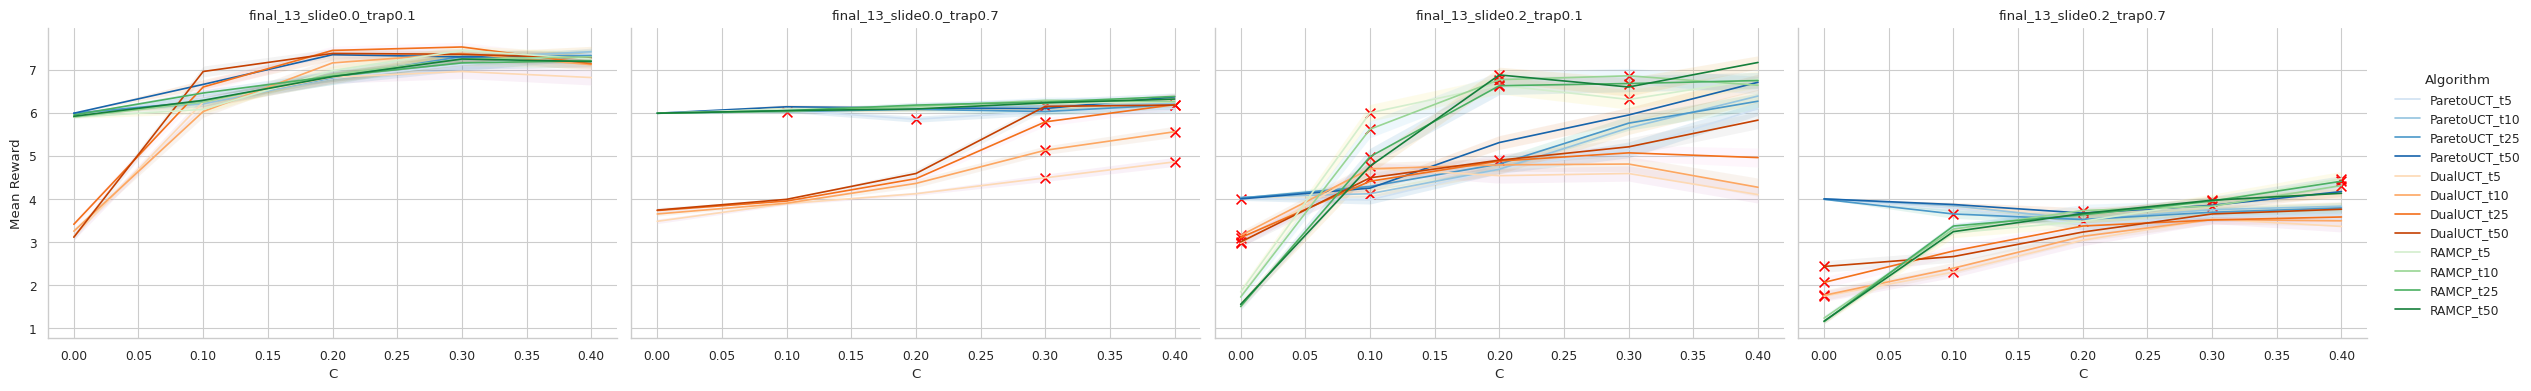

In [109]:
import matplotlib.pyplot as plt

# Plot meand reward vs. c
# Each benchmark is a subplot
# Each algorithm is a line
# Use `std_reward` for error bars


palette_algorithm1 = sns.color_palette("Blues", 4)
palette_algorithm2 = sns.color_palette("Oranges", 4)
palette_algorithm3 = sns.color_palette("Greens", 4)
palette = palette_algorithm1 + palette_algorithm2 + palette_algorithm3

# Create a FacetGrid with the benchmark feature
g = sns.FacetGrid(agent_data, col="benchmark", col_wrap=4, height=4, aspect=1.5)

# Map the lineplot to each subplot
g.map_dataframe(sns.lineplot, x='c', y='mean_reward', hue='algorithm', palette=palette, err_style='band', err_kws={'alpha': 0.2})

# Iterate through each subplot to add error bars manually
for ax, (benchmark_value, subset) in zip(g.axes.flatten(), agent_data.groupby('benchmark')):
    for algorithm_value in subset['algorithm'].unique():
        subset_algo = subset[subset['algorithm'] == algorithm_value]
        ax.fill_between(
            subset_algo['c'],
            subset_algo['mean_reward'] - subset_algo['std_reward'],
            subset_algo['mean_reward'] + subset_algo['std_reward'],
            alpha=0.1
        )
        non_feasible = subset_algo[subset_algo['feasible'] == False]
        ax.scatter(non_feasible['c'], non_feasible['mean_reward'], color='red', marker='x', s=50, label='Non-feasible')

# Adjust the titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("C", "Mean Reward")
g.add_legend(title='Algorithm')

g.savefig('mean_reward_vs_c.svg')


